<a href="https://colab.research.google.com/github/babaroscopy/colab/blob/main/CNN_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [8]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
ls

chest_xray/  chest-xray-pneumonia.zip  gdrive/  sample_data/


In [ ]:
pwd

'/content'

In [4]:
# Location of Zip File
drive_path = '/content/gdrive/My Drive/Kaggle/chest-xray-pneumonia.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'chest-xray-pneumonia.zip'

replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix

In [6]:
#Define Directories for train, test & Validation Set
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
valid_path = '/content/chest_xray/val'

In [7]:
#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500

In [8]:
# Create data generators
# File path = path to train/test/val folders respectively
# Using a target size of 500x500 px for each image (or whatever size you choose)
# Batch size = total number of images in the train set, test set, val set respectively(can choose less as RAM will be consumed)
# Ensure class_mode is binary(set it to “binary” if you’re only predicting 2 classes)
#Using 1./255 rescales the image pixels to a scale of 0–1 because the RGB pixel scale for images is from 1–255

# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                   rescale = 1./255
                                 #  shear_range = 0.2,
                                 #  zoom_range = 0.2,
                                 #  horizontal_flip = True,
                              
                               )  
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)


#using flow from directory to read the images from folders containing images
train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
  #  batch_size=5216,
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
#      batch_size=624
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
  #    batch_size=16
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [9]:
# let's build the CNN model

cnn = Sequential()
#cnn.add(Conv2D(Filter value,(filter/kernel size e.g 3,3),activation='relu/sigmoid',input_shape=(width,height,channels)))
cnn.add(Conv2D(16, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))  
#output=(width-kernelsize+stride, height-kernelsize+stride, no. of filters)
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2))) #, strides=None, padding="valid"  (can be added or it's by default)

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))    #outputs the input directly if it is positive, otherwise it outputs zero
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

In [11]:
#to stop the epochs based on some metric(monitor) and conditions (mode, patience)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
#patience is number of epochs with no improvement
#patience says that after a minimum val_loss is achieved then after that in next iterations if the val_loss increases in any the 3 iterations then the the training will stop at that epoch.


#Reduce learning rate when a metric(monitor) has stopped improving.
#(monitor,patience,factor(by which the learning rate will be reduced),min_lr(lower bound on the learning rate))
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [12]:
#from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight( 'balanced',classes=np.unique(train.classes),y=train.classes)
#weights = compute_class_weight('balanced', np.unique(train), train)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [13]:
#The parameters we are passing to model.fit are train set, epochs, validation set used to calculate val_loss and val_accuracy, class weights and callback list.
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
326/326 [==============================] - 111s 242ms/step - loss: 0.3017 - accuracy: 0.8551 - val_loss: 0.3142 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/25
326/326 [==============================] - 71s 217ms/step - loss: 0.1451 - accuracy: 0.9459 - val_loss: 0.1869 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/25
326/326 [==============================] - 71s 217ms/step - loss: 0.1004 - accuracy: 0.9599 - val_loss: 0.0955 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/25
326/326 [==============================] - 72s 219ms/step - loss: 0.0791 - accuracy: 0.9674 - val_loss: 0.5542 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/25
326/326 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9709
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 72s 221ms/step - loss: 0.0641 - accuracy: 0.9709 - val_loss: 0.1691 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/25
326/326 [========================

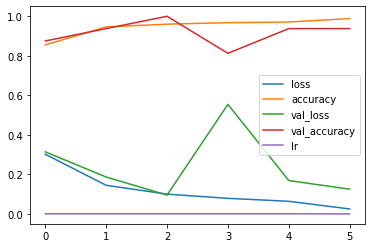

In [14]:
#progress of all metrics throughout the total epochs lifetime
pd.DataFrame(cnn.history.history).plot()

In [15]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 7s 175ms/step - loss: 1.6903 - accuracy: 0.7548
The testing accuracy is : 75.4807710647583 %


In [16]:
#predict the test dataset and look at some of the performance measurement metrics
preds = cnn.predict(test,verbose=1)

#the activation function of the last layer is sigmoid, the model gives prediction in the 0 to 1 range and not an exact classification as 0 or 1. So we categorise all the values in the 0.5 to 1 range as 0 and less than 0.5 as 1
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

39/39 [==============================] - 7s 168ms/step


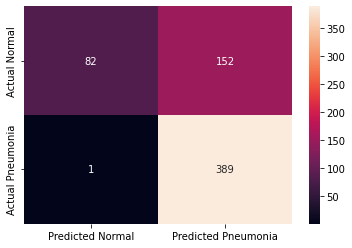

In [17]:
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [18]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.35      0.52       234
   PNEUMONIA       0.72      1.00      0.84       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.68       624
weighted avg       0.82      0.75      0.72       624

